<a href="https://colab.research.google.com/github/laurabrin/Classifying-EMPA-mineral-data/blob/adding-input/Classifying_mineral_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifying Electron Microprobe Mineral Data Using KNN and Decision Tree Algorithms#

The goal of this project will be to produce both KNN and Decision Tree models to determine the mineral classification for Electron Microprobe (EMP) data. 

Part 1 will be to create and optimize the two models for recall. Part 2 will assess whether KNN or decision tree classification algorithm is better at correctly labelling EMP mineral data. 

Loading libraries and data needed

In [2]:
import pandas as pd
import numpy as np
import time as time
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus



In [3]:
df_emp7030 = pd.read_csv("/content/70-30-EMPA.csv")

#The Data#

Electron microprobe analysis (EPMA) is a non-destructive tool commonly for determining mineral composition. A beam of electrons is directed at a mineral sample, exciting the outer electron. When the electrons return to their original state, the resulting x-rays are collected and measured and assigned to particular elements. The concentration of minor elements in a minerals chemical composition can assist in telling the story of how a particular rock was formed (temperature, presssure).

In this project we will be using the measurements from 12 element oxides to classify the EMPA sample into 7 minerals: olivine, garnet, clinopyroxene, orthopyroxene, nickel oxide, chromite and spinel. Minerals have a defined chemical structure that should lend itself well to classification. In manual classification, the ratio between major elements (Si, Mg, Fe, Al) determines the mineral assignment. I am interested to see if either model will over-emphasize the importance of minor elements, which will almost certainly lead to overfitting and poor accuracy.

Mineral Assignment no=nickel oxide, chr=chromite, cpx=clinopyroxene, grt=garnet, ol-olivinne, opx=orthopyroxene, sp=spinel


In [4]:
df_emp7030.head(15)

,Mineral,Name,SiO2,TiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,MnO,FeO,NiO,Na2O,K2O,Total,Date,dataset
0,no,P3-6-2,0.04,0.05,31.79,10.33,0.12,16.77,0.00,0.00,0.01,25.44,0.15,0.14,84.85,2012-03-14 5:49,test
1,no,P4-9-6,0.05,0.00,40.51,12.62,0.14,17.54,0.01,0.00,0.01,28.74,0.17,0.12,99.90,2012-03-13 22:08,train
2,no,P4-9-7,0.06,0.00,40.55,12.64,0.15,16.78,0.00,0.01,0.01,28.84,0.17,0.14,99.36,2012-03-13 22:11,train
3,no,P4-1-4,0.97,0.00,40.68,12.15,0.15,17.23,0.00,0.00,0.01,29.19,0.16,0.19,100.72,2012-03-13 19:38,test
4,no,P3-9-5,0.04,0.00,32.29,12.29,0.15,15.86,0.03,0.00,0.00,31.16,0.07,0.09,91.98,2012-03-14 7:19,train
5,no,P3-8-2,0.06,0.00,34.49,11.32,0.12,17.45,0.00,0.00,0.01,31.17,0.13,0.12,94.87,2012-03-14 6:47,train
6,no,P1-14,0.08,0.03,38.03,11.08,0.13,18.32,0.00,0.00,0.01,31.56,0.13,0.19,99.55,2012-03-14 8:49,train
7,no,P4-18-3,0.05,0.00,37.39,11.19,0.12,17.56,0.00,0.00,0.01,32.66,0.13,0.17,99.27,2012-03-14 0:35,test
8,no,P3-8-5,0.08,0.00,35.61,12.31,0.16,16.56,0.00,0.01,0.00,33.08,0.09,0.12,98.03,2012-03-14 6:59,train
9,no,P4-22-17,0.03,0.00,37.11,12.89,0.13,16.27,0.00,0.01,0.00,33.31,0.10,0.09,99.94,2012-03-14 3:05,train


In [5]:
df_emp7030.dtypes

Mineral     object
Name        object
SiO2       float64
TiO2       float64
Al2O3      float64
V2O3       float64
Cr2O3      float64
MgO        float64
CaO        float64
MnO        float64
FeO        float64
NiO        float64
Na2O       float64
K2O        float64
Total      float64
Date        object
dataset     object
dtype: object

In [6]:
df_emp7030['Mineral'].unique()

array(['no', 'sp', 'chr', 'cpx', 'grt', 'ol', 'opx', 'opx '], dtype=object)

In [7]:
df_emp7030.replace(to_replace="opx ", value="opx",inplace=True)
df_emp7030.replace(to_replace="train", value=0,inplace=True)
df_emp7030.replace(to_replace="test", value=1,inplace=True)

In [8]:
df_emp7030.drop(df_emp7030[df_emp7030["Name"]=="P1-17"].index, inplace=True)

In [9]:
oxides=["SiO2","TiO2","Al2O3","V2O3","Cr2O3","MgO","CaO","MnO","FeO","NiO","Na2O","K2O","Total"]
oxides_striped=["SiO2","Al2O3","V2O3","Cr2O3","MgO","CaO","FeO","NiO"]

In [10]:
df_emp7030.describe()

,SiO2,TiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,MnO,FeO,NiO,Na2O,K2O,Total,dataset
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,39.289039,0.036717,6.628002,1.542310,5.309401,37.049938,3.582360,0.117453,5.634145,0.647054,0.123883,0.008115,99.970200,0.300874
std,17.416101,0.153362,12.183133,3.121899,12.219481,15.161968,7.925315,0.104040,4.335071,3.791068,0.201071,0.042415,2.251215,0.458925
min,0.000000,-0.030000,-0.010000,-0.020000,-0.020000,9.920000,0.000000,-0.020000,-0.010000,-0.010000,-0.010000,-0.010000,71.260000,0.000000
25%,40.070000,0.000000,0.010000,0.000000,0.020000,18.400000,0.010000,0.060000,1.310000,0.030000,0.000000,0.000000,99.380000,0.000000
50%,41.250000,0.000000,1.040000,0.020000,0.130000,36.280000,0.010000,0.110000,6.710000,0.090000,0.010000,0.000000,100.050000,0.000000
75%,53.780000,0.010000,2.370000,0.170000,0.650000,51.610000,0.410000,0.130000,7.690000,0.370000,0.280000,0.010000,100.870000,1.000000
max,59.000000,2.690000,44.070000,13.210000,59.390000,53.940000,24.500000,0.660000,27.240000,34.850000,1.080000,1.090000,103.210000,1.000000


In [11]:
for index in oxides:  
  df_emp7030[index]=df_emp7030[index].clip(lower=0)
df_emp7030.head(15)

,Mineral,Name,SiO2,TiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,MnO,FeO,NiO,Na2O,K2O,Total,Date,dataset
0,no,P3-6-2,0.04,0.05,31.79,10.33,0.12,16.77,0.00,0.00,0.01,25.44,0.15,0.14,84.85,2012-03-14 5:49,1
1,no,P4-9-6,0.05,0.00,40.51,12.62,0.14,17.54,0.01,0.00,0.01,28.74,0.17,0.12,99.90,2012-03-13 22:08,0
2,no,P4-9-7,0.06,0.00,40.55,12.64,0.15,16.78,0.00,0.01,0.01,28.84,0.17,0.14,99.36,2012-03-13 22:11,0
3,no,P4-1-4,0.97,0.00,40.68,12.15,0.15,17.23,0.00,0.00,0.01,29.19,0.16,0.19,100.72,2012-03-13 19:38,1
4,no,P3-9-5,0.04,0.00,32.29,12.29,0.15,15.86,0.03,0.00,0.00,31.16,0.07,0.09,91.98,2012-03-14 7:19,0
5,no,P3-8-2,0.06,0.00,34.49,11.32,0.12,17.45,0.00,0.00,0.01,31.17,0.13,0.12,94.87,2012-03-14 6:47,0
6,no,P1-14,0.08,0.03,38.03,11.08,0.13,18.32,0.00,0.00,0.01,31.56,0.13,0.19,99.55,2012-03-14 8:49,0
7,no,P4-18-3,0.05,0.00,37.39,11.19,0.12,17.56,0.00,0.00,0.01,32.66,0.13,0.17,99.27,2012-03-14 0:35,1
8,no,P3-8-5,0.08,0.00,35.61,12.31,0.16,16.56,0.00,0.01,0.00,33.08,0.09,0.12,98.03,2012-03-14 6:59,0
9,no,P4-22-17,0.03,0.00,37.11,12.89,0.13,16.27,0.00,0.01,0.00,33.31,0.10,0.09,99.94,2012-03-14 3:05,0


In [12]:
mask1=df_emp7030["Total"].values>90
df_emp7030=df_emp7030.loc[mask1]


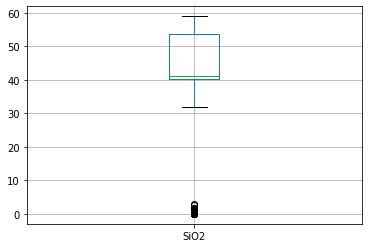

In [13]:
df_emp7030.boxplot(column="SiO2")

In [14]:
df_emp7030["Mineral"].describe()

count     793
unique      7
top        ol
freq      377
Name: Mineral, dtype: object

#Part 1 


KNN

In [15]:
df_knn=df_emp7030.copy()
X_train=df_knn.loc[df_emp7030["dataset"]==0]
X_train=X_train.drop(["Mineral","Name","Date","dataset","MnO","Na2O","K2O","TiO2","Total"],axis=1)

X_test=df_knn.loc[df_emp7030["dataset"]==1]
X_test=X_test.drop(["Mineral","Name","Date","dataset","MnO","Na2O","K2O","TiO2","Total"],axis=1)

y_train=df_knn.query("dataset==0")["Mineral"]
y_test=df_knn.query("dataset==1")["Mineral"]

In [16]:
X_train.head(10)

,SiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,FeO,NiO
1,0.05,40.51,12.62,0.14,17.54,0.01,0.01,28.74
2,0.06,40.55,12.64,0.15,16.78,0.00,0.01,28.84
4,0.04,32.29,12.29,0.15,15.86,0.03,0.00,31.16
5,0.06,34.49,11.32,0.12,17.45,0.00,0.01,31.17
6,0.08,38.03,11.08,0.13,18.32,0.00,0.01,31.56
8,0.08,35.61,12.31,0.16,16.56,0.00,0.00,33.08
9,0.03,37.11,12.89,0.13,16.27,0.00,0.00,33.31
11,0.04,35.51,12.98,0.14,16.12,0.04,0.00,34.85
14,0.37,38.41,0.12,26.92,18.24,0.02,14.48,0.10
15,0.08,39.05,0.16,28.32,17.08,0.23,12.18,0.19


In [17]:
knn=KNeighborsClassifier(n_neighbors=7)

In [18]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [19]:
y_predict=knn.predict(X_test)


In [20]:
print(f"knn accuracy score:", accuracy_score(y_test,y_predict))
print(f"knn recall score:", recall_score(y_test,y_predict, average="macro"))
print(f"knn precision score:", precision_score(y_test,y_predict, average="weighted"))
print(f"knn f1 score:", f1_score(y_test,y_predict,average="weighted"))

knn accuracy score: 0.9958333333333333
knn recall score: 0.8571428571428571
knn precision score: 0.9918010752688172
knn f1 score: 0.9937841530054644


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DECISION TREE

In [21]:
df_tree=df_emp7030.copy()
X_train2=df_tree.loc[df_emp7030["dataset"]==0]
X_train2=X_train2.drop(["Mineral","Name","Date","dataset","MnO","Na2O","K2O","TiO2","Total"],axis=1)

X_test2=df_tree.loc[df_emp7030["dataset"]==1]
X_test2=X_test2.drop(["Mineral","Name","Date","dataset","MnO","Na2O","K2O","TiO2","Total"],axis=1)

y_train2=df_tree.query("dataset==0")["Mineral"]
y_test2=df_tree.query("dataset==1")["Mineral"]

In [22]:
tree=DecisionTreeClassifier(min_samples_leaf=3)

In [23]:
tree.fit(X_train2,y_train2)

DecisionTreeClassifier(min_samples_leaf=3)

In [24]:
y_predict2=tree.predict(X_test2)

In [25]:
print(f"tree accuracy score:", accuracy_score(y_test2,y_predict2))
print(f"tree recall score:", recall_score(y_test2,y_predict2, average="macro"))
print(f"tree precision score:", precision_score(y_test2,y_predict2, average="weighted"))
print(f"tree f1 score:", f1_score(y_test2,y_predict2,average="weighted"))
print(classification_report(y_test2,y_predict2))

tree accuracy score: 1.0
tree recall score: 1.0
tree precision score: 1.0
tree f1 score: 1.0
              precision    recall  f1-score   support

         chr       1.00      1.00      1.00         1
         cpx       1.00      1.00      1.00        30
         grt       1.00      1.00      1.00        18
          no       1.00      1.00      1.00         3
          ol       1.00      1.00      1.00       114
         opx       1.00      1.00      1.00        44
          sp       1.00      1.00      1.00        30

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



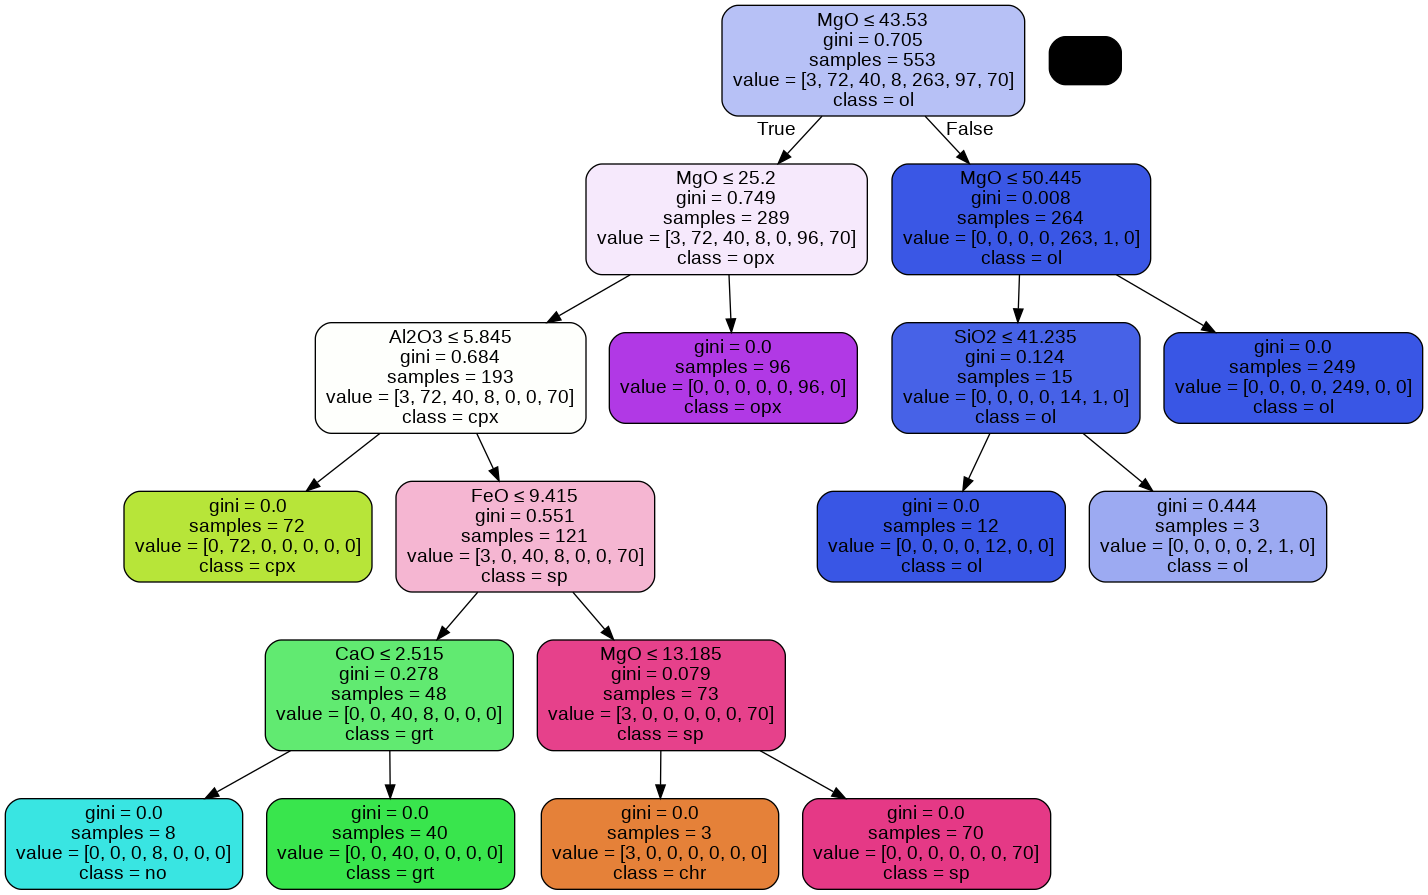

In [26]:
#Tree visualization
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=oxides_striped, class_names= tree.classes_, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#Part 2: Model Assessments and visualizations#

In [27]:
input = pd.read_csv("/content/input_test_set.csv")

In [28]:
input.dropna(axis=0, how="all",inplace=True)

In [29]:
input.head()

,Mineral,Name,SiO2,TiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,MnO,FeO,NiO,Na2O,K2O,Total,Date,dataset
0,ukn,LB12-117,56.14,0.00,2.59,0.01,0.48,33.85,2.33,0.14,4.57,0.08,0.07,0.00,100.26,2012-02-17 3:33,input
1,ukn,LB12-134,47.50,0.01,0.01,0.00,0.00,46.93,0.01,0.01,4.98,0.34,0.00,0.01,99.79,2012-02-17 4:39,input
2,ukn,LB3-93,33.83,0.00,0.02,0.01,0.01,55.73,0.02,0.13,9.49,0.44,0.00,0.00,99.67,2012-02-18 7:40,input
3,ukn,LB10-22,35.07,0.01,0.02,0.00,0.00,58.61,0.01,0.11,7.11,0.34,0.01,0.01,101.31,2012-02-18 9:15,input
4,ukn,LB10-12,53.40,0.03,2.93,0.01,1.67,33.36,4.25,0.10,4.46,0.06,0.14,0.00,100.41,2012-02-18 8:35,input


In [30]:
for index in oxides:  
  input[index]=input[index].clip(lower=0)


In [31]:
X_input=input.drop(["Mineral","Name","Date","dataset","MnO","Na2O","K2O","TiO2","Total","dataset"],axis=1)
X_input_UK=X_input[:8]
X_input=X_input[8:]
y_input=input["Mineral"][8:]
y_input_UK=input["Mineral"][:8]


In [32]:
y_input.shape

(202,)

In [33]:
X_input.fillna(0,inplace=True)

In [34]:
input_predict_knn=knn.predict(X_input)
input_predict_tree=tree.predict(X_input)


In [35]:
input_accuracy_knn=accuracy_score(y_input,input_predict_knn)
input_accuracy_tree=accuracy_score(y_input,input_predict_tree)
print(f"knn:",input_accuracy_knn)
print(f"tree:",input_accuracy_tree)

knn: 0.9801980198019802
tree: 0.9851485148514851


In [36]:
input_accuracy_compare=accuracy_score(input_predict_knn,input_predict_tree)
print(f"comparing both together:",input_accuracy_compare)

comparing both together: 0.995049504950495


#Part 3: New Data

import new data

In [65]:
xls = pd.ExcelFile('/content/New_data_template.xlsx')
df_new=pd.read_excel(xls, 'Format')
df_new=df_new.loc[~(df_new==0).all(axis=1)]
new_x=df_new.drop(["Name","MnO","Na2O","K2O","TiO2","Total"],axis=1)


In [66]:
new_predict=knn.predict(new_x)
new_predict

array(['grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt',
       'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt',
       'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt', 'grt',
       'grt', 'grt', 'grt', 'grt', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp',
       'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp',
       'sp', 'sp', 'sp', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx',
       'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx', 'cpx',
       'cpx', 'cpx', 'cpx', 'cpx'], dtype=object)

In [67]:
from pandas.core.internals import concat
new_predict_df=pd.DataFrame(new_predict, columns=["Mineral"])
print_df=pd.merge(df_new, new_predict_df, left_index=True, right_index=True)
print_df

,Name,SiO2,TiO2,Al2O3,V2O3,Cr2O3,MgO,CaO,MnO,FeO,NiO,Na2O,K2O,Total,Mineral
0,1-1a,39.81,0.18,16.73,0,6.69,17.10,4.81,0.56,12.81,0,0.16,0,98.84,grt
1,1-1,40.04,0.07,17.66,0,6.97,17.98,7.13,0.67,8.36,0,0.13,0,99.01,grt
2,1-2,40.20,0.07,18.42,0,5.52,19.51,5.41,0.65,8.61,0,0.02,0,98.50,grt
3,1-3,38.73,0.06,23.25,0,0.07,14.58,1.29,3.23,19.32,0,0.00,0,100.54,grt
4,1-4,40.55,0.26,20.38,0,4.37,21.79,5.21,0.41,7.54,0,0.04,0,100.53,grt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,SNOW_GOOSE-CPX-4-16,55.53,0.30,1.77,0,1.12,16.65,20.41,0.03,2.40,0,1.77,0,99.98,cpx
67,SNOW_GOOSE-CPX-4-17,55.85,0.31,1.75,0,1.20,16.32,20.43,0.01,2.40,0,1.78,0,100.05,cpx
68,SNOW_GOOSE-CPX-4-18,55.35,0.29,1.73,0,1.23,16.35,20.36,0.01,2.33,0,1.89,0,99.54,cpx
69,SNOW_GOOSE-CPX-4-19,56.60,0.28,1.79,0,1.29,16.50,20.52,0.00,2.46,0,1.85,0,101.29,cpx


In [68]:
print_df.to_excel("New_data_assigned.xlsx",sheet_name='Mineral Assign') 

Retrieve mineral assignment from New_data_assigned spreadsheet